# StyleGAN latent space exploration

## План занятие:
1. Подробнее разобрать StyleGaN
2. Генерация рандомных лиц с помощью StyleGAN 2
3. Исследование разных методовов инверсии  
4. Визуализация точек из латентного пространства и анализ результатов
5. Манипуляции с векторами   


https://github.com/NVlabs/stylegan2-ada-pytorch?tab=readme-ov-file [stylegan2-ada github]

https://github.com/christianversloot/machine-learning-articles/blob/main/stylegan-a-step-by-step-introduction.md [stylegan intro]

https://arxiv.org/pdf/1812.04948.pdf [stylegan]

https://arxiv.org/pdf/1912.04958.pdf [stylegan2]

https://arxiv.org/pdf/2006.06676.pdf [stylegan2-ada]

https://nn.labml.ai/gan/stylegan/index.html [stylegan code explaned]

https://oscar-guarnizo.medium.com/review-image2stylegan-embedding-an-image-into-stylegan-c7989e345271 [latent space]

https://github.com/omertov/encoder4editing?tab=readme-ov-file [encoder for edinig]


## Install dependencies

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# %rm -rf /content/some

In [ ]:
!pip install ninja
!pip install imageio-ffmpeg
!pip install -U -q PyDrive
!pip install lpips
!pip install pytorch_msssim
!pip install pytorch-ignite


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

%mkdir raw_images
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch
%cd stylegan2-ada-pytorch
!git clone https://github.com/denkogit/stylegan2_models


!mkdir pretrained_models
%cd pretrained_models
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d /content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat.bz2

file_id = '1cUv_reLE6k3604or78EranS7XzuVMWeO' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('e4e_ffhq_encode.pt')

%cd ..
# ref https://github.com/Puzer/stylegan-encoder/blob/master/align_images.py
# !git clone https://github.com/omertov/encoder4editing


Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 7.33 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/stylegan2-ada-pytorch
Cloning into 'stylegan2_models'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
Receiving objects: 100% (57/57), 25.54 KiB | 12.77 MiB/s, done.
Resolving deltas: 100% (14/14), done.
remote: Total 57 (delta 14), reused 48 (delta 7), pack-reused 0
/content/stylegan2-ada-pytorch/pretrained_models
--2024-03-29 10:34:57--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.18.33, 52.84.18.79, 52.84.18.96, ...
Connecting to nvlabs-fi-cdn.nvidia.com 

## Download images and vectors

In [ ]:
file_id = '1WoiQmg7k-XKYSVNMvAZm_QUqAo_gK5uE' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/celebs.zip')

file_id = '10zYE9lkYq6SuMVL0MaTv4YSuwdg_Wbhg' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/editing.zip')

In [ ]:
!unzip /content/celebs.zip -d /content/
!unzip /content/editing.zip -d /content/
! rm -rf /content/__MACOSX

Archive:  /content/celebs.zip
   creating: /content/celebs/
   creating: /content/celebs/AJoly/
  inflating: /content/celebs/AJoly/34c7bef704ac52844e402f6b9b804904.jpg  
  inflating: /content/celebs/AJoly/andzhelina-dzholi-press-konferenciya-neslomlennaya.jpg  
  inflating: /content/celebs/AJoly/67d860b7b0c3be3b216d3d1d059ad424.jpg  
  inflating: /content/celebs/AJoly/f60a8c8e515a1f63c7444842e004447c.jpg  
  inflating: /content/celebs/AJoly/b11ec6657c1d1e413b326e746fd35151.jpg  
   creating: /content/celebs/EMerphy/
  inflating: /content/celebs/EMerphy/kinodrive.com-271-123172.jpg  
  inflating: /content/celebs/EMerphy/18659.jpg  
  inflating: /content/celebs/EMerphy/140.jpg  
  inflating: /content/celebs/EMerphy/2.63451136-1537x2048.jpg  
  inflating: /content/celebs/EMerphy/bolshoj-papochka-57-letnij-eddi-merfi-stanet-otcom-v-desyatyj-raz.jpg  
   creating: /content/celebs/Stethem/
  inflating: /content/celebs/Stethem/stethem6.jpg  
  inflating: /content/celebs/Stethem/1646466328_27-

## Align images

In [ ]:
import os
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector


landmarks_model_path = "/content/stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "/content/celebs"
ALIGNED_IMAGES_DIR = "/content/aligned_images"

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

In [ ]:
!zip -r /content/aligned_images.zip /content/aligned_images

  adding: content/aligned_images/ (stored 0%)
  adding: content/aligned_images/Stethem/ (stored 0%)
  adding: content/aligned_images/Stethem/1.jpg (deflated 0%)
  adding: content/aligned_images/Stethem/4.jpg (deflated 0%)
  adding: content/aligned_images/Stethem/0.jpg (deflated 0%)
  adding: content/aligned_images/Stethem/3.jpg (deflated 0%)
  adding: content/aligned_images/Stethem/2.jpg (deflated 0%)
  adding: content/aligned_images/KJunJin/ (stored 0%)
  adding: content/aligned_images/KJunJin/1.jpg (deflated 0%)
  adding: content/aligned_images/KJunJin/4.jpg (deflated 0%)
  adding: content/aligned_images/KJunJin/0.jpg (deflated 0%)
  adding: content/aligned_images/KJunJin/3.jpg (deflated 0%)
  adding: content/aligned_images/KJunJin/2.jpg (deflated 0%)
  adding: content/aligned_images/AJoly/ (stored 0%)
  adding: content/aligned_images/AJoly/1.jpg (deflated 0%)
  adding: content/aligned_images/AJoly/4.jpg (deflated 0%)
  adding: content/aligned_images/AJoly/0.jpg (deflated 0%)
  addin

# StyleGAN face generation

## StyleGAN face generation

In [ ]:
import os
os.chdir("/content/stylegan2-ada-pytorch")
print(os.getcwd())


/content/stylegan2-ada-pytorch


In [ ]:
!python3 generate.py --outdir=out --trunc=0.0 --network=pretrained_models/ffhq.pkl --seeds=42

Loading networks from "pretrained_models/ffhq.pkl"...
Generating image for seed 42 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# image = ((image * std) + mean)
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


In [ ]:
seed = 42
noise_mode = 'const' # шум
label = 0 # для разных моделей
device = "cuda:0"
model_path = "/content/stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


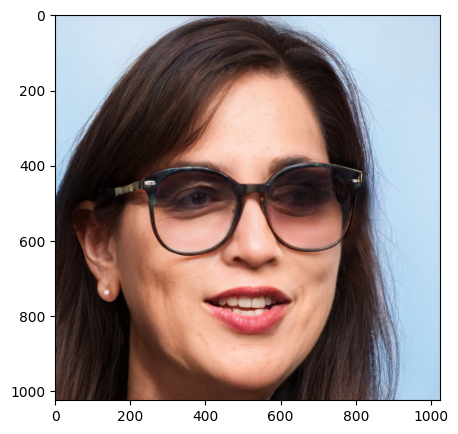

In [ ]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label)

generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor, (5,5))


## Truncation


truncation - интерполяция в сторону среднего вектора



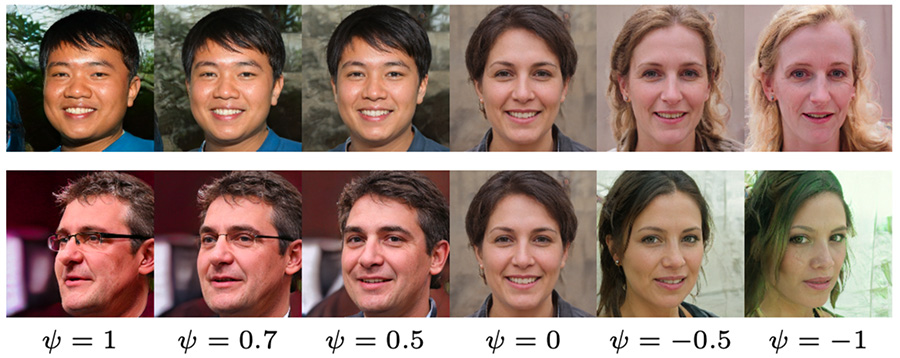

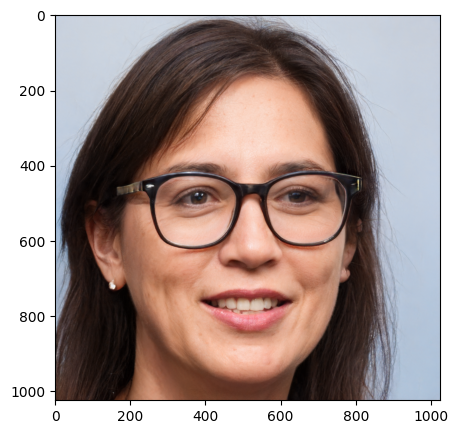

In [ ]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
ws = G.mapping(z, label, truncation_psi=(0.7))

generated_tensor = G.synthesis(ws, noise_mode=noise_mode, force_fp32=True)
plot_image(generated_tensor, (5,5))

## Projection of real images

In [ ]:
!python3 projector.py --outdir=out --num-steps=200 --target=/content/aligned_images/LDCaprio/0.jpg --network=pretrained_models/ffhq.pkl

Loading networks from "pretrained_models/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/200: dist 0.64 loss 24567.31
step    2/200: dist 0.67 loss 27640.65
step    3/200: dist 0.70 loss 25424.12
step    4/200: dist 0.57 loss 21587.75
step    5/200: dist 0.51 loss 16983.14
step    6/200: dist 0.59 loss 12129.86
step    7/200: dist 0.56 loss 7881.28
step    8/200: dist 0.50 loss 4645.48
step    9/200: dist 0.48 loss 3097.60
step   10/200: dist 0.47 loss 3350.19
step   11/200: dist 0.41 loss 4911.86
step   12/200: dist 0.39 loss 6623.40
step   13/200: dist 0.45 loss 7760.33
step   14/200: dist 0.43 loss 7769.15
step   15/200: dist 0.45 loss 7015.73
step   16/200: dist 0.44 loss 5725.30
step   17/200: dist 0.41 loss 4315.13
step   18/200: dist 0.43 loss 3162.13
step   19/200: dist 0.41 loss 2329.47
step   20/200: dist 0.43 loss 1751.46
step   21/200: dis

In [ ]:
!rm -r out

Проекция это поиск точки в латентном пространстве которая визуально будет похожа на реальное изображение


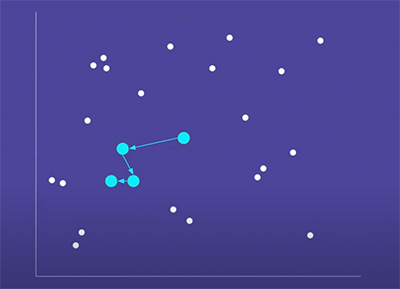

In [ ]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F



# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor


# загружаем изображение
inv_img_path = "/content/aligned_images/AJoly/0.jpg"
target_pil = Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)


# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()

noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
reg_loss = Reg_loss(noise_bufs)

#  loss weights
regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# Параметры для оптимизации
num_steps = 50
seed = 40
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

# w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()

  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


114595.5546875


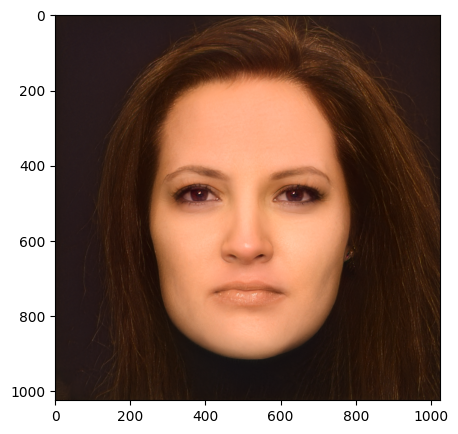

In [ ]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
import imageio

def save_video(video_path):
  video = imageio.get_writer(video_path, mode='I', fps=10, codec='libx264', bitrate='16M')
  target_uint8 = np.array(target_pil, dtype=np.uint8)
  print (f'Saving optimization progress video {video_path}')
  for synth_image in generated_tensors:
      synth_image = (synth_image + 1) * (255/2)
      synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
      video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
  video.close()

video_path = "/content/proj_video.mp4"
save_video(video_path)

Saving optimization progress video /content/proj_video.mp4


### Encoder for editing

https://arxiv.org/pdf/2102.02766.pdf

Ld-reg - позволяет дельтам не расходиться

Ladv - Дискриминатор сравнивает латенты

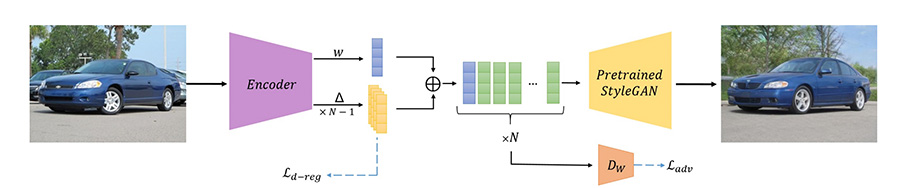

In [ ]:
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


In [ ]:
image_path = "/content/aligned_images/AJoly/0.jpg"
target_pil = Image.open(image_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)
print(initial_latent_vector.size())

torch.Size([1, 18, 512])


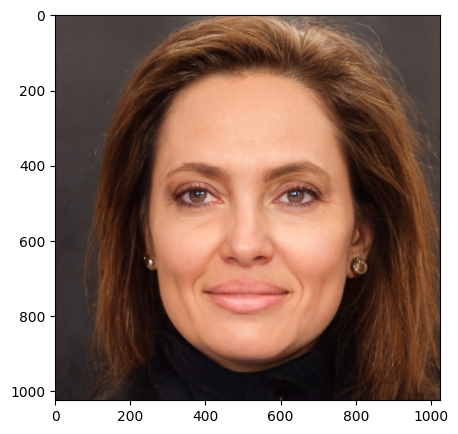

In [ ]:
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)
plot_image(generated_tensor, (5,5))

In [ ]:
import torch.nn as nn
from tqdm import tqdm


num_steps = 50
learning_rate = 0.01
initial_latent_vector = nn.Parameter(initial_latent_vector, requires_grad=True)

optimizer = torch.optim.Adam([initial_latent_vector], lr=learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(initial_latent_vector, noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


114595.4609375


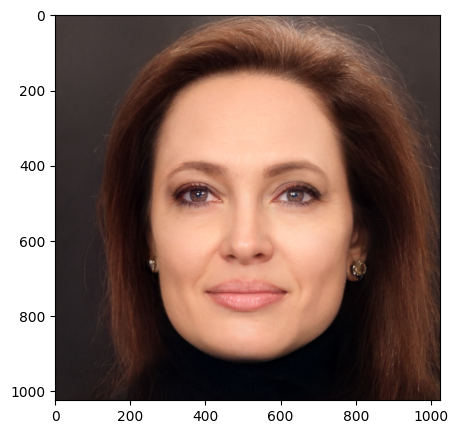

In [ ]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
video_path = "/content/proj_video_e4e.mp4"
save_video(video_path)

Saving optimization progress video /content/proj_video_e4e.mp4


## Plot latent using PCA

Метод главных компонент

https://habr.com/ru/post/304214/

In [ ]:
import os
import glob
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



images_path = "/content/aligned_images"
save_path = "/content/e4e_invertion"

data = []
for persone in sorted(os.listdir(images_path)):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(save_path, persone)
    os.makedirs(save_folder, exist_ok=True)

    for image_name in os.listdir(person_images):
      image_path = os.path.join(person_images, image_name)

      target_pil = Image.open(image_path).convert('RGB')
      target_uint8 = np.array(target_pil, dtype=np.uint8)

      e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)

      latent_vector = e4e_model(e4e_tensor).detach().cpu()
      latent_path = os.path.join(save_folder, f"{image_name[:-4]}.pt")

      torch.save(latent_vector, latent_path)
      data.append([persone, image_name, image_path, latent_path])

df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

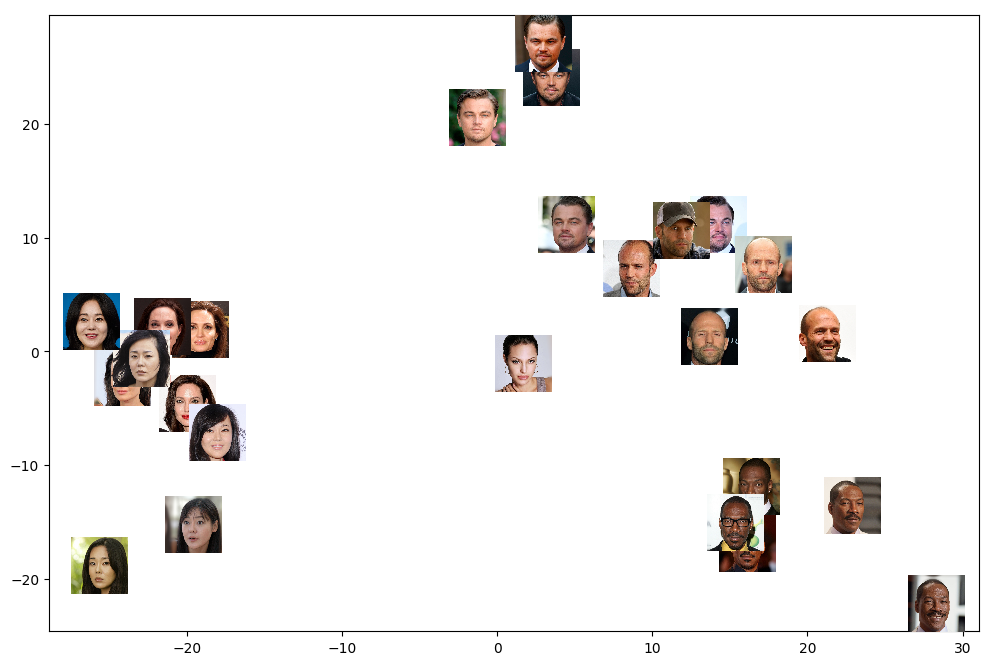

In [ ]:

def getImage(path, zoom=0.04):
    return OffsetImage(plt.imread(path), zoom=zoom)

embedings = []
for index, row in df.iterrows():
    latent_path = row["latent_path"]
    latent = torch.load(latent_path).numpy().squeeze(0)
    embedings.append(latent)

batch = np.stack(embedings, axis=0)
batch = batch.reshape((25, 9216))
pca = PCA(n_components=2, random_state=22).fit(batch)
x = pca.transform(batch)

fig, ax = plt.subplots(figsize=(12,8))
# for x, y, path in zip(x[:, 0], x[:, 1], df.image_path.values.tolist()):
for x, y, df_iter in zip(x[:, 0], x[:, 1], df.iterrows()):
  i, row = df_iter
  path = row["image_path"]
  label = row["key"]
  ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
  ax.add_artist(ab)
  plt.scatter(x,y, label=label)

# plt.legend()
plt.show()




## Interpolation and editing

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# %rm -rf /content/e4e_invertion

In [ ]:
! mv /content/stylegan2-ada-pytorch/editing /content


mv: cannot stat '/content/stylegan2-ada-pytorch/editing': No such file or directory


In [ ]:
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch


def interpolate(latent1, latent2, psi=0.5, indeces=[i for i in range(0,18)]):
    init_latent = latent1.clone()
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)

    edited_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    init_tensor = G.synthesis(init_latent, noise_mode='const', force_fp32=True)
    plot_image(torch.cat((init_tensor, edited_tensor ), dim=3), (10,10))




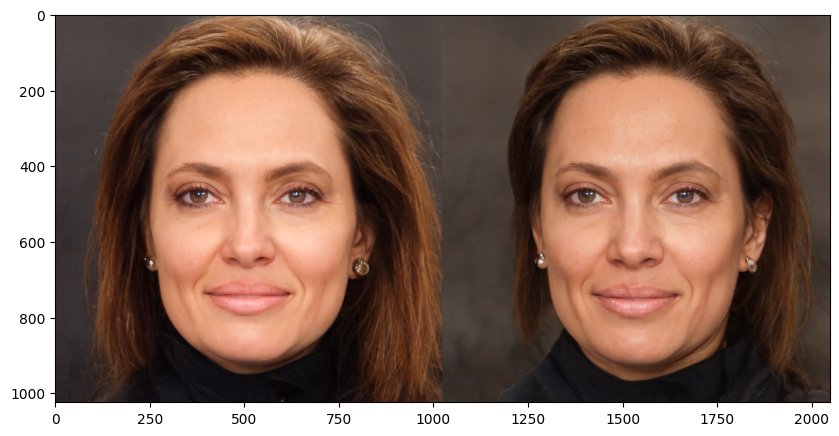

In [ ]:
latent1=torch.load("/content/e4e_invertion/AJoly/0.pt").to(device)
latent2=torch.load("/content/e4e_invertion/EMerphy/4.pt").to(device)

interpolate(latent1, latent2, psi=0.8)

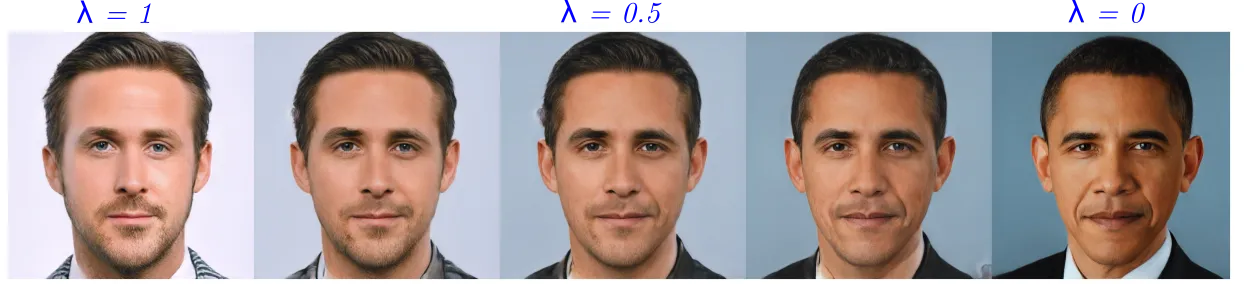

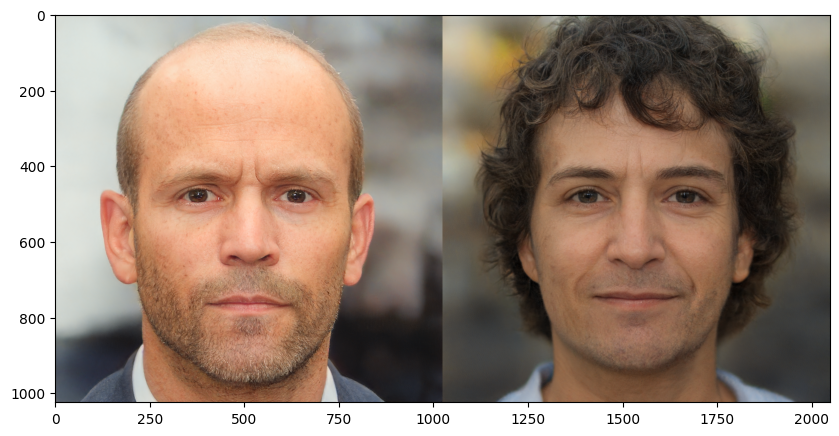

In [ ]:

latent1=torch.load("/content/e4e_invertion/Stethem/2.pt").to(device)
# latent1 = initial_latent_vector

# latent2=torch.load("/content/editing/age.pt").to(device)
# latent2=torch.load("/content/editing/pose.pt").to(device)
latent2=torch.load("/content/editing/smile.pt").to(device) # 0.5, 1.5 indeces = [0,1,2,3,4,5,6]
# latent2 = broadcast_w_sg(latent2)


# interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2),
#             psi=widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.1))


indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# indeces = [0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,17]
interpolate(latent1, latent2, psi=0.2, indeces=indeces)

# Homework

In [ ]:
file_id = '1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5' # URL id.
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ms1mv3_arcface_r50_fp16.pth')


In [67]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor



class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

# https://drive.google.com/file/d/1QIPdkYyIwqEUS8jBNouWo9eYzr3DwDd5/view?usp=sharing ссылка на загрузку весов
arcface_path = "/content/stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "/content/aligned_images/LDCaprio/4.jpg"

arcface_loss = Arcface_Loss(weights_path=arcface_path,device=device)

e4e_model, _ = load_e4e_standalone("/content/stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

image2e4etensor = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


target_pil = Image.open(attr_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)


image_path = "/content/aligned_images/KJunJin/2.jpg"
target_pil_face = Image.open(image_path).convert('RGB')
target_uint8_face = np.array(target_pil_face, dtype=np.uint8)
target_tensor_face = image2tensor_norm(target_pil_face).to(device).unsqueeze(0)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)

In [1]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F



# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))


# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

# image = (image - mean) / std
def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor


# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()

noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
reg_loss = Reg_loss(noise_bufs)


#  loss weights
regularize_noise_weight = 5e5
rec_weight = 0.4
lpips_weoght = 1.5

# Параметры для оптимизации
num_steps = 100
seed = 40
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)

# w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)
generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  arcface_value = arcface_loss(target_tensor_face, synth_tensor)

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight + arcface_value

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()

  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")
print(loss.item())

ModuleNotFoundError: No module named 'lpips'

In [ ]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
plot_image(target_tensor, plot_size=(5,5))

In [ ]:
plot_image(target_tensor_face, plot_size=(5,5))

# .